In [1]:
import numpy as np
import os
from gan_training.distributions import get_zdist
from sklearn.manifold import TSNE
%matplotlib inline
import seaborn as sns  
import pandas as pd
sns.set()           

/home/zhangzr/anaconda3/envs/wgan_torch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def load_latentvecs(latentvec_dir, num):


    # load latent vectors npy file
    for i,filename in enumerate(os.listdir(latentvec_dir)):
        if i == 0:
            latent_vecs = np.load(latentvec_dir + filename)
        else:
            current_vecs = np.load(latentvec_dir + filename)
            latent_vecs = np.concatenate((current_vecs,latent_vecs),axis=0)
        
    total_num = latent_vecs.shape[0]
    np.random.shuffle(latent_vecs)
    return latent_vecs[total_num-num:,:]


In [3]:
flowers_latentvec_dir = 'output/vec2img/flowers_small_lr/latentvecs/'
cars_latentvec_dir = 'output/vec2img/cars_256dim/latentvecs/'
num = 200
samples_flowers = load_latentvecs(flowers_latentvec_dir, num) 
sample_cars = load_latentvecs(cars_latentvec_dir, num)
zdist = get_zdist('gauss', 256, device='cpu')
samples_normal = zdist.sample((num,)).numpy() 
all_samples = np.concatenate((samples_flowers, sample_cars, samples_normal),axis=0)
print('all sample shape: ', all_samples.shape)

all_samples_df = pd.DataFrame(all_samples)

split_value = ['flowers' for i in range(num)]
for i in range(num):
    split_value.append('cars')

for i in range(num):
    split_value.append('imagenet')

all_samples_df.insert(loc=0, column='split', value=split_value)

all sample shape:  (600, 256)


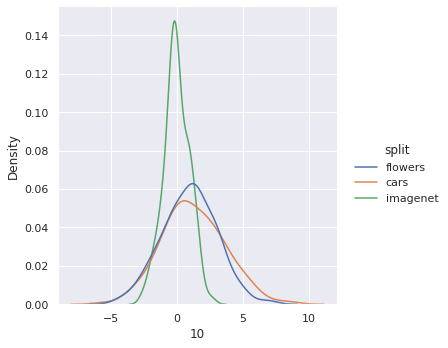

In [4]:
sns.displot(data = all_samples_df, x=10, hue="split", kind="kde")

In [5]:
print('Computing t-SNE embedding')
# TSEN default: perplexity=30, n_iter=1000
tsne = TSNE(n_components=2, random_state=12345, perplexity=30, n_iter=1000)  # init='pca'
proj_results = tsne.fit_transform(all_samples)
proj_results_df = pd.DataFrame(proj_results)

proj_results_df.insert(loc=0, column='split', value=split_value)

Computing t-SNE embedding


/home/zhangzr/anaconda3/envs/wgan_torch/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/zhangzr/anaconda3/envs/wgan_torch/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


<AxesSubplot:xlabel='0', ylabel='1'>

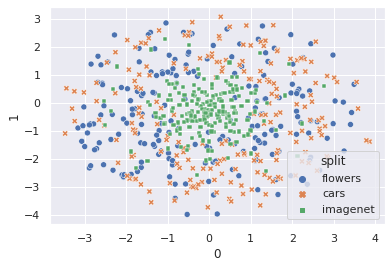

In [6]:
sns.scatterplot(data=proj_results_df, x=0, y=1, hue='split', style="split")

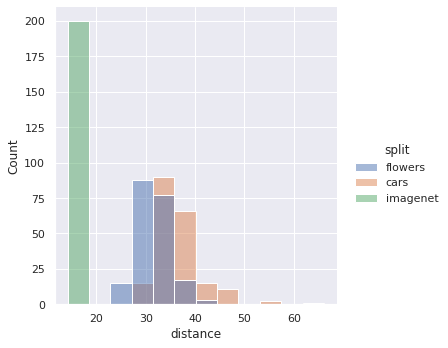

In [7]:
# compute distance to mean
all_distance = []
flower_mean = np.mean(samples_flowers,axis=0)
for i in range(num):
    dist = np.linalg.norm(samples_flowers[i,:] - flower_mean)
    all_distance.append(dist)

car_mean = np.mean(sample_cars,axis=0)
for i in range(num):
    dist = np.linalg.norm(sample_cars[i,:] - car_mean)
    all_distance.append(dist)




imagenet_mean = np.mean(samples_normal,axis=0)
for i in range(num):
    dist = np.linalg.norm(samples_normal[i,:] - imagenet_mean)
    all_distance.append(dist)

distance_df = pd.DataFrame()
distance_df.insert(loc=0, column='distance', value=all_distance)
distance_df.insert(loc=0, column='split', value=split_value)

sns.displot(data = distance_df, x='distance', hue='split')